# Avaliação Interativa - Projeto Coruja

**Objetivo:** Este notebook serve para avaliar o desempenho do detector de humanos (`Projeto Coruja`) em um conjunto variado de imagens.

Vamos carregar o modelo YOLOv8, preparar algumas imagens de teste (casos positivos, negativos e desafiadores) e visualizar os resultados de forma interativa.

In [1]:
# Importações necessárias
import cv2
import requests
from pathlib import Path
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Configuração para que o Matplotlib exiba as imagens dentro do notebook
%matplotlib inline

## 1. Carregando o Modelo

Primeiro, vamos carregar o modelo YOLOv8 pré-treinado. O arquivo `.pt` será baixado automaticamente pela biblioteca `ultralytics` na primeira execução.

In [2]:
# Carrega o modelo YOLOv8n (nano), que é rápido e leve.
try:
    model_path = Path("../models/yolov8n.pt")
    modelo = YOLO(model_path)
    print("✅ Modelo YOLOv8 carregado com sucesso!")
except Exception as e:
    print(f"❌ Erro ao carregar o modelo: {e}")

✅ Modelo YOLOv8 carregado com sucesso!


## 2. Preparando as Imagens de Teste

Para uma avaliação justa, precisamos de imagens variadas. O código abaixo irá criar uma pasta `imagens_para_avaliacao/` e baixar automaticamente 5 imagens de teste da internet:

1.  **Humano Claro:** Uma imagem fácil com uma pessoa em destaque.
2.  **Múltiplos Humanos:** Uma cena com várias pessoas.
3.  **Paisagem:** Uma imagem sem pessoas ou animais (verdadeiro negativo).
4.  **Animal:** Uma imagem com um animal, para testar se o modelo o confunde com um humano (falso positivo comum em sensores de movimento).
5.  **Humano Distante:** Um caso mais difícil, com uma pessoa pequena na cena.

In [3]:
# Dicionário com as URLs das imagens de teste
imagens_urls = {
    "multiplos_humanos.jpg": "https://images.pexels.com/photos/837358/pexels-photo-837358.jpeg",
    "humano.jpg": "https://images.pexels.com/photos/1181519/pexels-photo-1181519.jpeg",
    "paisagem.jpg": "https://images.pexels.com/photos/3244513/pexels-photo-3244513.jpeg",
    "gato.jpg": "https://images.pexels.com/photos/1170986/pexels-photo-1170986.jpeg",
    "humano_distante.jpg": "https://images.pexels.com/photos/1322129/pexels-photo-1322129.jpeg"
}

# Cria o diretório para salvar as imagens
output_dir = Path("../data/imagens_para_avaliacao")
output_dir.mkdir(exist_ok=True)

# Baixa cada imagem
for nome_arquivo, url in imagens_urls.items():
    caminho_arquivo = output_dir / nome_arquivo
    if not caminho_arquivo.exists():
        print(f"Baixando {nome_arquivo}...")
        try:
            response = requests.get(url, stream=True)
            response.raise_for_status()
            with open(caminho_arquivo, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
        except requests.exceptions.RequestException as e:
            print(f"  Falha ao baixar {nome_arquivo}: {e}")
    else:
        print(f"Arquivo {nome_arquivo} já existe.")

print("\n✅ Imagens de teste prontas!")

Arquivo multiplos_humanos.jpg já existe.
Arquivo humano.jpg já existe.
Arquivo paisagem.jpg já existe.
Arquivo gato.jpg já existe.
Arquivo humano_distante.jpg já existe.

✅ Imagens de teste prontas!


## 3. Função de Análise e Visualização

Agora, vamos criar uma função que recebe o caminho de uma imagem, executa a detecção e exibe o resultado visualmente aqui no notebook.

In [4]:
def analisar_e_visualizar_imagem(caminho_imagem: Path, confianca_minima: float = 0.25):
    """
    Executa a detecção em uma imagem, imprime o resultado e exibe a imagem com as detecções.
    """
    print("-" * 50)
    print(f"🦉 Analisando: {caminho_imagem.name}")

    # ID da classe 'person' no dataset COCO
    ID_CLASSE_PESSOA = 0
    encontrado = False
    confianca_max = 0.0

    # Executa a inferência
    results = modelo(caminho_imagem, verbose=False)

    # Processa o resultado para encontrar humanos
    for box in results[0].boxes:
        if int(box.cls[0]) == ID_CLASSE_PESSOA and float(box.conf[0]) > confianca_minima:
            encontrado = True
            confianca_max = max(confianca_max, float(box.conf[0]))
            
    # Imprime o resultado textual
    if encontrado:
        print(f"✅ Humano detectado: Sim (Confiança máx: {confianca_max:.2%})")
    else:
        print("❌ Humano detectado: Não")

    # Gera e exibe a imagem com as detecções
    # O método .plot() retorna uma imagem em formato BGR (padrão OpenCV)
    imagem_resultado_bgr = results[0].plot()
    
    # Matplotlib espera imagens em formato RGB, então precisamos converter
    imagem_resultado_rgb = cv2.cvtColor(imagem_resultado_bgr, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 8))
    plt.imshow(imagem_resultado_rgb)
    plt.axis('off')  # Esconde os eixos x e y
    plt.show()

## 4. Executando a Avaliação

Finalmente, vamos iterar sobre nossas imagens de teste e usar nossa função para ver o modelo em ação.

--------------------------------------------------
🦉 Analisando: gato.jpg
❌ Humano detectado: Não


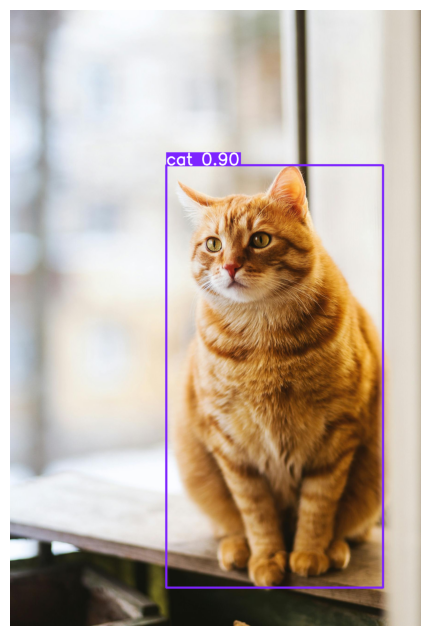

--------------------------------------------------
🦉 Analisando: humano.jpg
✅ Humano detectado: Sim (Confiança máx: 93.43%)


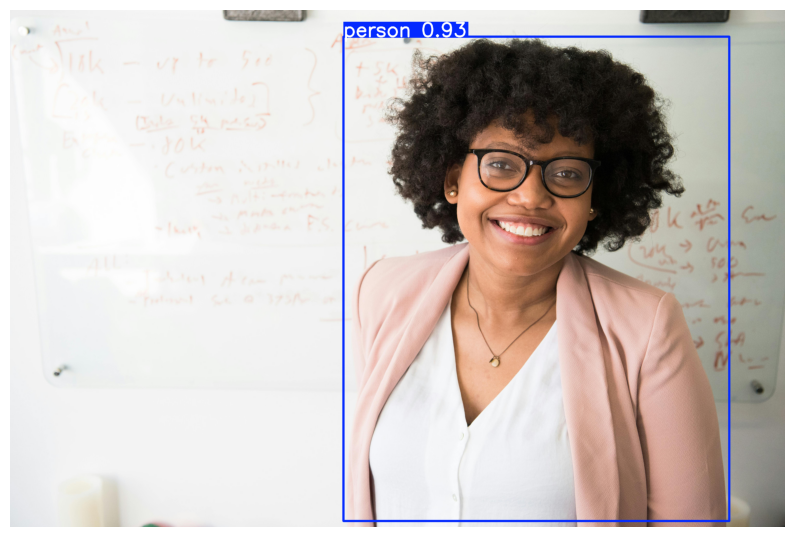

--------------------------------------------------
🦉 Analisando: humano_distante.jpg
✅ Humano detectado: Sim (Confiança máx: 70.52%)


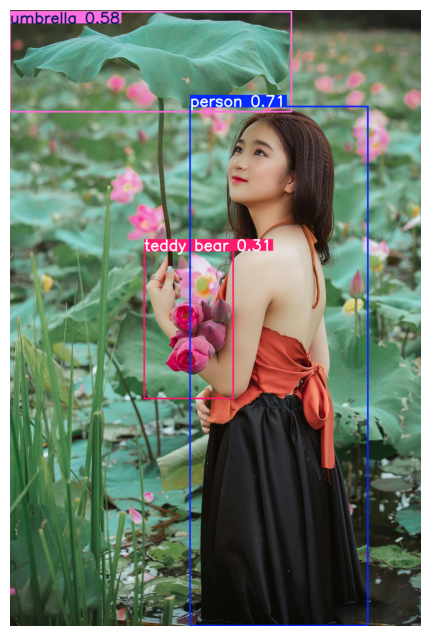

--------------------------------------------------
🦉 Analisando: multiplos_humanos.jpg
✅ Humano detectado: Sim (Confiança máx: 82.08%)


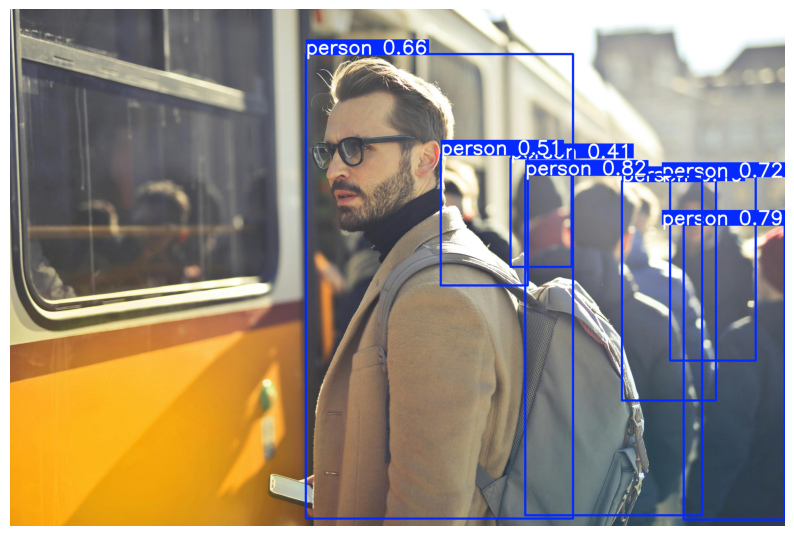

--------------------------------------------------
🦉 Analisando: paisagem.jpg
❌ Humano detectado: Não


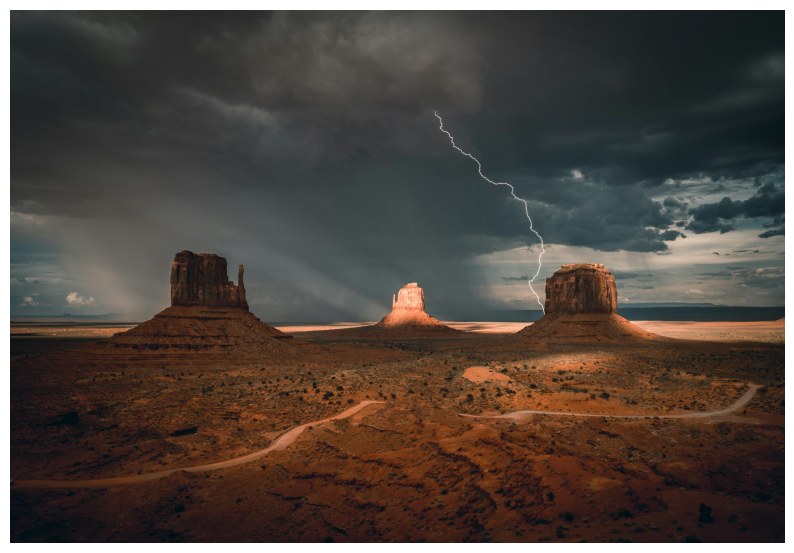

In [5]:
# Lista de caminhos para todas as imagens baixadas
caminhos_imagens = sorted(list(output_dir.glob("*.jpg")))

# Executa a análise para cada imagem
for caminho in caminhos_imagens:
    analisar_e_visualizar_imagem(caminho)

## 5. Conclusão e Próximos Passos

Este notebook demonstrou a capacidade do modelo YOLOv8 em detectar humanos em diferentes cenários. Observamos que ele é eficaz em identificar pessoas em primeiro plano e em grupos, e não gera falsos positivos com paisagens ou animais. A detecção de pessoas distantes pode ser mais desafiadora, como esperado.

**Próximos Passos para uma Avaliação Mais Robusta:**
* **Dataset de Validação:** Utilizar um dataset maior com anotações (labels) para calcular métricas formais como precisão (precision) e sensibilidade (recall).
* **Análise de Vídeo:** Adaptar o código para processar frames de um vídeo e avaliar a estabilidade da detecção ao longo do tempo.
* **Teste de Limites:** Testar com imagens de baixa luminosidade, parcialmente obstruídas ou com artefatos de câmera para entender os limites do modelo.